In [1]:
import pandas as pd
from nltk.tokenize import sent_tokenize, PunktSentenceTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import math
from rouge import Rouge
from tqdm.notebook import tqdm
import seaborn as sns
import numpy as np
import pickle
sns.set()

In [2]:
def show(x):
    print(x.shape)
    return x.head()

In [3]:
references = pd.read_csv("../data/references.csv").dropna()
show(references)
references.head(10)

(5035, 3)


,global_reference_id,title,abstract
0,0,Distributed Representations of Words and Phras...,The recently introduced continuous Skip-gram m...
1,1,BERT: Pre-training of Deep Bidirectional Trans...,We introduce a new language representation mod...
2,2,Attention Is All You Need,The dominant sequence transduction models are ...
3,3,GloVe : Global Vectors for Word Representation,Recent methods for learning vector space repre...
4,4,Adam: A Method for Stochastic Optimization,"We introduce Adam, an algorithm for first-orde..."
6,6,Deep Contextualized Word Representations,We introduce a new type of deep contextualized...
7,7,Neural Machine Translation By Jointly Learning...,Neural machine translation is a recently propo...
8,8,Efficient Estimation of Word Representations i...,We propose two novel model architectures for c...
9,9,Deep Residual Learning for Image Recognition,Deeper neural networks are more difficult to t...
11,11,Distributed Representations of Sentences and D...,Many machine learning algorithms require the i...


In [4]:
papers = pd.read_csv("../data/papers.csv")
show(papers)

(1091, 4)


,paper_id,title,abstract,text
0,0,IDST at TREC 2019 Deep Learning Track: Deep Ca...,This paper describes our participation in the ...,"KEYWORDS cascade ranking, pre-trained language..."
1,1,BatchBALD: Efficient and Diverse Batch Acquisi...,"We develop BatchBALD, a tractable approximatio...",A key problem in deep learning is data efficie...
2,2,A Sentence Compression Based Framework to Quer...,We consider the problem of using sentence comp...,Proceedings of the 51st Annual Meeting of the ...
3,3,DR-BiLSTM: Dependent Reading Bidirectional LST...,We present a novel deep learning architecture ...,Natural Language Inference (NLI; a.k.a. Recogn...
4,4,On Minimizing Cost in Legal Document ReviewWor...,Technology-assisted review (TAR) refers to hum...,CCS CONCEPTS • Information systems → Informati...


In [5]:
citations = pd.read_csv("../data/citations.csv")
show(citations)

(56746, 6)


,paper_id,internal_reference_id,global_reference_id,context,start_offset,end_offset
0,0,1,1,Our approach is mainly based on the BERT langu...,56,59
1,0,8,475,Different from many other ranking methods whic...,216,219
2,0,5,155,"Moreover, for full ranking subtask, we use a s...",78,81
3,0,6,25,The proposed model is based on the pointer-gen...,59,62
4,0,6,25,"Following [7], we also use a soft switch to ch...",10,13


# retrieving sentences

In [6]:
query_papers = citations.paper_id.value_counts().reset_index()\
.rename(columns = {"index":"paper_id", "paper_id":"references"})\
.merge(papers.drop(columns = ["title", "abstract"]))
show(query_papers)

(1091, 3)


,paper_id,references,text
0,482,718,This survey provides a synthesis of existing w...
1,647,718,This survey provides a synthesis of existing w...
2,595,599,commercial world. To provide an overview of th...
3,650,563,1 Interactive Clustering: A Comprehensive Revi...
4,372,491,"In this survey, we provide a synthesis of exis..."


In [7]:
papers.query("paper_id == 191")

,paper_id,title,abstract,text
191,191,The Benefits of Word Embeddings Features for A...,This study investigates the use of unsupervise...,Active learning (AL) has recently received con...


In [8]:
query_references = citations.global_reference_id.value_counts()\
.reset_index()\
.rename(columns = {"index":"global_reference_id", "global_reference_id":"citations"})\
.merge(references.dropna().drop(columns = "title"), right_index = True, left_on = "global_reference_id")
show(query_references)

(4135, 5)


,global_reference_id,global_reference_id_x,citations,global_reference_id_y,abstract
0,1,1,497,1,We introduce a new language representation mod...
1,2,2,257,2,The dominant sequence transduction models are ...
2,0,0,247,0,The recently introduced continuous Skip-gram m...
3,3,3,215,3,Recent methods for learning vector space repre...
4,8,8,184,8,We propose two novel model architectures for c...


In [9]:
query_citations = citations.merge(query_references)[["paper_id", "global_reference_id"]].drop_duplicates()
show(query_citations)

(10984, 2)


,paper_id,global_reference_id
0,0,1
2,7,1
6,8,1
12,12,1
18,17,1


In [10]:
# tokenizer = PunktSentenceTokenizer()
tokenizer = PunktSentenceTokenizer(train_text = papers.text.sum())
tokenizer

In [11]:
# model = CountVectorizer()
model = TfidfVectorizer()
model.fit(query_references.abstract)

TfidfVectorizer()

In [12]:
query_embeddings = model.transform(query_references.abstract)
print(query_embeddings.shape)

(4135, 16420)


In [13]:
sentence_embeddings = []
for p in tqdm(query_papers.text):
    s = tokenizer.tokenize(p)
    sentence_embeddings.append((np.array(s), model.transform(s)))
print(len(sentence_embeddings))
print(len(sentence_embeddings[0][0]), sentence_embeddings[0][1].shape)

  0%|          | 0/1091 [00:00<?, ?it/s]

1091
5973 (5973, 16420)


In [14]:
query_ids = query_references\
.global_reference_id\
.reset_index(drop = True)\
.reset_index()\
.set_index("global_reference_id")["index"]
show(query_ids)

(4135,)


global_reference_id
1    0
2    1
0    2
3    3
8    4
Name: index, dtype: int64

In [15]:
paper_ids = query_papers\
.paper_id\
.reset_index(drop = True)\
.reset_index()\
.set_index("paper_id")["index"]
show(paper_ids)

(1091,)


paper_id
482    0
647    1
595    2
650    3
372    4
Name: index, dtype: int64

In [16]:
data = query_citations.to_dict("records")#[:5]
sentence_scores = []
for d in tqdm(data):
    paper = d["paper_id"]
    reference = d["global_reference_id"]
    qe = query_embeddings[query_ids[reference]]
    sentences, embeddings = sentence_embeddings[paper_ids[paper]]
#     print(qe.shape)
#     print(embeddings.shape)
#     sim = cosine_similarity(qe.toarray(), embeddings.toarray()).flatten()
#     sim = (qe.toarray() @ embeddings.toarray().T).flatten()
    sim = (qe @ embeddings.T).toarray().flatten()
    df = pd.DataFrame({"text":sentences, "relevance_to_query":sim})\
    .assign(paper_id = paper, global_reference_id = reference)
    sentence_scores.append(df)
sentence_scores = pd.concat(sentence_scores, axis = 0)
show(sentence_scores)

  0%|          | 0/10984 [00:00<?, ?it/s]

(6389984, 4)


,text,relevance_to_query,paper_id,global_reference_id
0,"KEYWORDS cascade ranking, pre-trained language...",0.042543,0,1
1,2020.,0.000000,0,1
2,IDST at TREC 2019 Deep Learning Track: Deep Ca...,0.074697,0,1
3,In Proceedings of ACM Conference (Conference’17).,0.004005,0,1
4,"ACM, New York, NY, USA, 4 pages.",0.010973,0,1


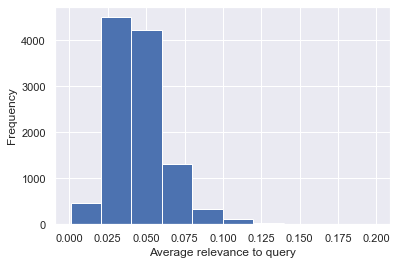

In [39]:
sentence_scores.groupby(["paper_id", "global_reference_id"]).relevance_to_query.mean().plot.hist()
plt.xlabel("Average relevance to query")
plt.show()

In [40]:
queries = sentence_scores.query("relevance_to_query > 0.4")\
.groupby(["paper_id", "global_reference_id"])\
.text.agg(lambda x: " ".join(x))\
.to_frame()\
.reset_index()\
.merge(references.drop(columns = ["title"]))\
.rename(columns = {"text":"hypothesis", "abstract":"reference"})\
.dropna()\
.reset_index(drop = True)

show(queries)

(1142, 4)


,paper_id,global_reference_id,hypothesis,reference
0,3,914,Natural Language Inference (NLI; a.k.a.,Natural Language Inference (NLI) task requires...
1,791,914,Natural Language Inference (NLI; a.k.a.,Natural Language Inference (NLI) task requires...
2,5,1925,The semantic parser converts natural language ...,Suppose we want to build a system that answers...
3,322,1925,The method does not require labeling sentences...,Suppose we want to build a system that answers...
4,6,1968,[11] study the maintenance of dense subgraphs ...,Recent years have witnessed an unprecedented p...


# rouge

In [41]:
rouge = Rouge()
scores = rouge.get_scores(hyps = queries.hypothesis, refs = queries.reference)
print(len(scores))
scores[:5]

1142


[{'rouge-1': {'r': 0.04395604395604396,
   'p': 0.6666666666666666,
   'f': 0.08247422564353281},
  'rouge-2': {'r': 0.016666666666666666,
   'p': 0.3333333333333333,
   'f': 0.03174603083900229},
  'rouge-l': {'r': 0.04395604395604396,
   'p': 0.6666666666666666,
   'f': 0.08247422564353281}},
 {'rouge-1': {'r': 0.04395604395604396,
   'p': 0.6666666666666666,
   'f': 0.08247422564353281},
  'rouge-2': {'r': 0.016666666666666666,
   'p': 0.3333333333333333,
   'f': 0.03174603083900229},
  'rouge-l': {'r': 0.04395604395604396,
   'p': 0.6666666666666666,
   'f': 0.08247422564353281}},
 {'rouge-1': {'r': 0.1875, 'p': 0.35, 'f': 0.24418604196863172},
  'rouge-2': {'r': 0.032679738562091505,
   'p': 0.06578947368421052,
   'f': 0.04366811783604477},
  'rouge-l': {'r': 0.16964285714285715,
   'p': 0.31666666666666665,
   'f': 0.22093022801514342}},
 {'rouge-1': {'r': 0.11607142857142858,
   'p': 0.24074074074074073,
   'f': 0.1566265016344899},
  'rouge-2': {'r': 0.013071895424836602,
   '

In [42]:
rouge_df = pd.DataFrame.from_records(scores)
show(rouge_df)

(1142, 3)


,rouge-1,rouge-2,rouge-l
0,"{'r': 0.04395604395604396, 'p': 0.666666666666...","{'r': 0.016666666666666666, 'p': 0.33333333333...","{'r': 0.04395604395604396, 'p': 0.666666666666..."
1,"{'r': 0.04395604395604396, 'p': 0.666666666666...","{'r': 0.016666666666666666, 'p': 0.33333333333...","{'r': 0.04395604395604396, 'p': 0.666666666666..."
2,"{'r': 0.1875, 'p': 0.35, 'f': 0.24418604196863...","{'r': 0.032679738562091505, 'p': 0.06578947368...","{'r': 0.16964285714285715, 'p': 0.316666666666..."
3,"{'r': 0.11607142857142858, 'p': 0.240740740740...","{'r': 0.013071895424836602, 'p': 0.02985074626...","{'r': 0.10714285714285714, 'p': 0.222222222222..."
4,"{'r': 0.09219858156028368, 'p': 0.590909090909...","{'r': 0.046632124352331605, 'p': 0.42857142857...","{'r': 0.09219858156028368, 'p': 0.590909090909..."


In [43]:
rouge_1 = pd.DataFrame.from_records(rouge_df["rouge-1"])\
.rename(columns = {"f":"rouge_1_f", "r":"rouge_1_r", "p":"rouge_1_p"})
show(rouge_1)

(1142, 3)


,rouge_1_r,rouge_1_p,rouge_1_f
0,0.043956,0.666667,0.082474
1,0.043956,0.666667,0.082474
2,0.187500,0.350000,0.244186
3,0.116071,0.240741,0.156627
4,0.092199,0.590909,0.159509


In [44]:
rouge_2 = pd.DataFrame.from_records(rouge_df["rouge-2"])\
.rename(columns = {"f":"rouge_2_f", "r":"rouge_2_r", "p":"rouge_2_p"})
show(rouge_2)

(1142, 3)


,rouge_2_r,rouge_2_p,rouge_2_f
0,0.016667,0.333333,0.031746
1,0.016667,0.333333,0.031746
2,0.032680,0.065789,0.043668
3,0.013072,0.029851,0.018182
4,0.046632,0.428571,0.084112


In [45]:
rouge_l = pd.DataFrame.from_records(rouge_df["rouge-l"])\
.rename(columns = {"f":"rouge_l_f", "r":"rouge_l_r", "p":"rouge_l_p"})
show(rouge_l)

(1142, 3)


,rouge_l_r,rouge_l_p,rouge_l_f
0,0.043956,0.666667,0.082474
1,0.043956,0.666667,0.082474
2,0.169643,0.316667,0.220930
3,0.107143,0.222222,0.144578
4,0.092199,0.590909,0.159509


In [46]:
full_rouge = pd.concat((queries, rouge_1, rouge_2, rouge_l), axis = 1)
show(full_rouge)

(1142, 13)


,paper_id,global_reference_id,hypothesis,reference,rouge_1_r,rouge_1_p,rouge_1_f,rouge_2_r,rouge_2_p,rouge_2_f,rouge_l_r,rouge_l_p,rouge_l_f
0,3,914,Natural Language Inference (NLI; a.k.a.,Natural Language Inference (NLI) task requires...,0.043956,0.666667,0.082474,0.016667,0.333333,0.031746,0.043956,0.666667,0.082474
1,791,914,Natural Language Inference (NLI; a.k.a.,Natural Language Inference (NLI) task requires...,0.043956,0.666667,0.082474,0.016667,0.333333,0.031746,0.043956,0.666667,0.082474
2,5,1925,The semantic parser converts natural language ...,Suppose we want to build a system that answers...,0.187500,0.350000,0.244186,0.032680,0.065789,0.043668,0.169643,0.316667,0.220930
3,322,1925,The method does not require labeling sentences...,Suppose we want to build a system that answers...,0.116071,0.240741,0.156627,0.013072,0.029851,0.018182,0.107143,0.222222,0.144578
4,6,1968,[11] study the maintenance of dense subgraphs ...,Recent years have witnessed an unprecedented p...,0.092199,0.590909,0.159509,0.046632,0.428571,0.084112,0.092199,0.590909,0.159509


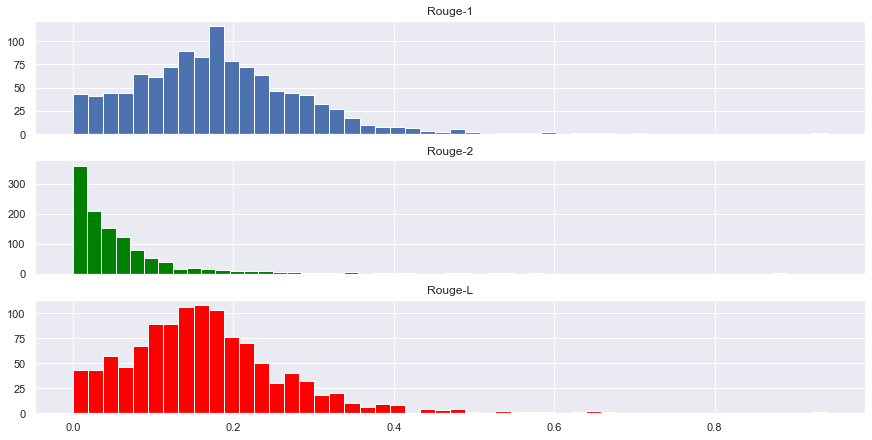

In [47]:
f, ax = plt.subplots(3, 1, sharex = True, constrained_layout=True, figsize = (12, 6))
ax[0].hist(full_rouge.rouge_1_f, bins = 50)
ax[0].set_title("Rouge-1")
ax[1].hist(full_rouge.rouge_2_f, bins = 50, color = "green")
ax[1].set_title("Rouge-2")
ax[2].hist(full_rouge.rouge_l_f, bins = 50, color = "red")
ax[2].set_title("Rouge-L")

plt.show()

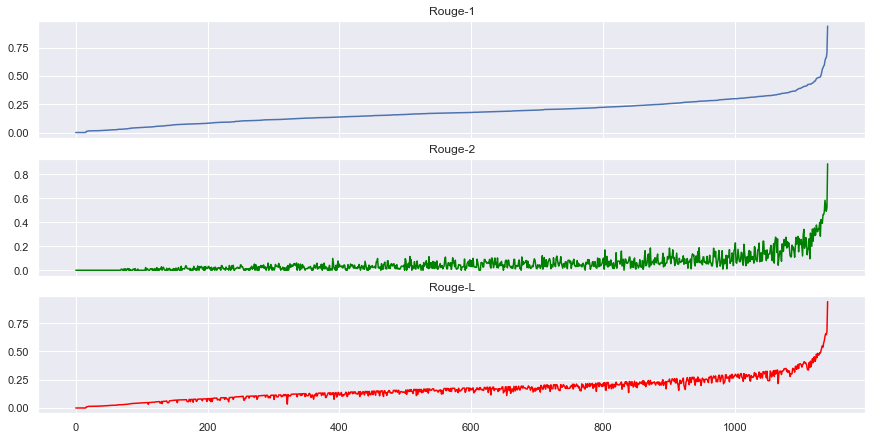

In [48]:
data = full_rouge.sort_values("rouge_1_f").reset_index()
f, ax = plt.subplots(3, 1, sharex = True, constrained_layout=True, figsize = (12, 6))
ax[0].plot(data.rouge_1_f)
ax[0].set_title("Rouge-1")
ax[1].plot(data.rouge_2_f, color = "green")
ax[1].set_title("Rouge-2")
ax[2].plot(data.rouge_l_f, color = "red")
ax[2].set_title("Rouge-L")

plt.show()

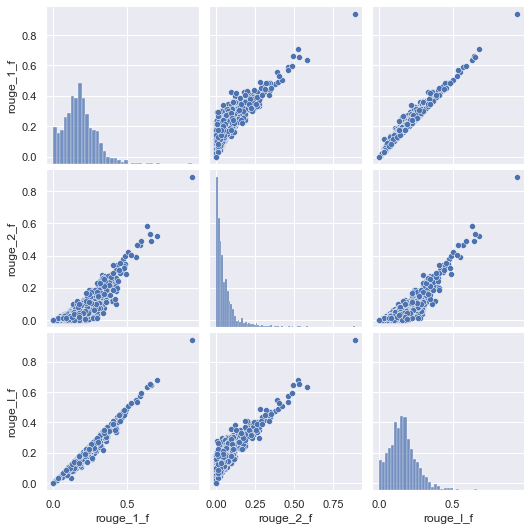

In [49]:
sns.pairplot(full_rouge, vars = ["rouge_1_f","rouge_2_f", "rouge_l_f"])
plt.show()

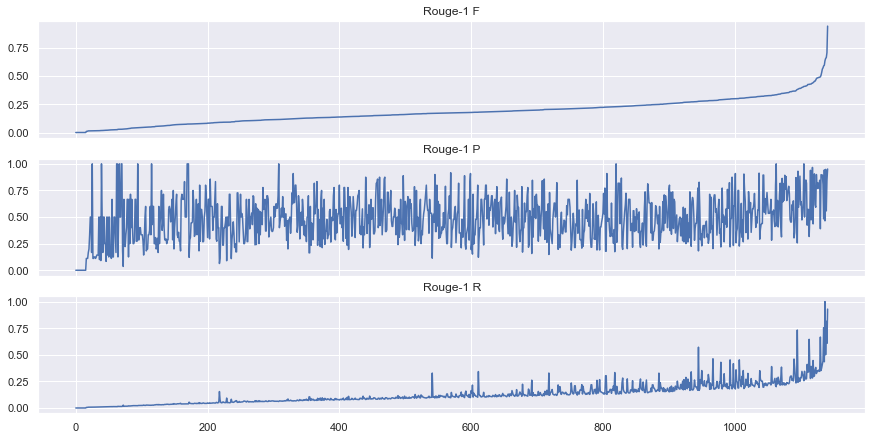

In [50]:
data = full_rouge.sort_values("rouge_1_f").reset_index()
f, ax = plt.subplots(3, 1, sharex = True, constrained_layout=True, figsize = (12, 6))
ax[0].plot(data.rouge_1_f)
ax[0].set_title("Rouge-1 F")
ax[1].plot(data.rouge_1_p)
ax[1].set_title("Rouge-1 P")
ax[2].plot(data.rouge_1_r)
ax[2].set_title("Rouge-1 R")

plt.show()

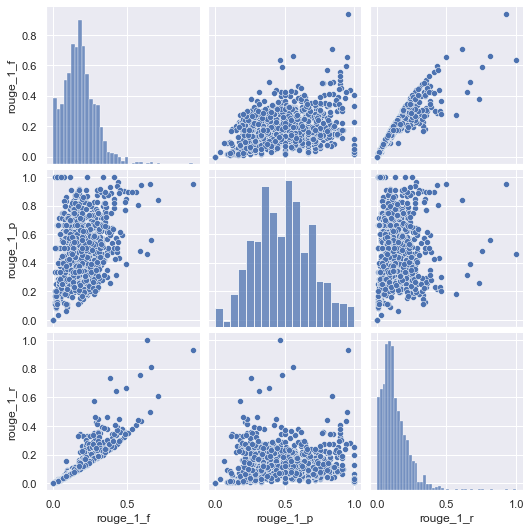

In [51]:
sns.pairplot(full_rouge, vars = ["rouge_1_f","rouge_1_p", "rouge_1_r"])
plt.show()

# inspection

# worst

In [52]:
for d in full_rouge.sort_values("rouge_1_f").head().to_dict("records"):
    print("paper_id:", d["paper_id"], ", global_reference_id:", d["global_reference_id"])
    print("rouge 1 f:", d["rouge_1_f"])
    print()
    print(d["hypothesis"])
    print()
    print(d["reference"])
    print("*"*30)

paper_id: 692 , global_reference_id: 15938
rouge 1 f: 0.0

Positive-unlabeled Learning.

We develop a classification algorithm for estimating posterior distributions from positive-unlabeled data, that is robust to noise in the positive labels and effective for high-dimensional data. In recent years, several algorithms have been proposed to learn from positive-unlabeled data; however, many of these contributions remain theoretical, performing poorly on real high-dimensional data that is typically contaminated with noise. We build on this previous work to develop two practical classification algorithms that explicitly model the noise in the positive labels and utilize univariate transforms built on discriminative classifiers. We prove that these univariate transforms preserve the class prior, enabling estimation in the univariate space and avoiding kernel density estimation for high-dimensional data. The theoretical development and both parametric and nonparametric algorithms proposed he

# best

In [53]:
for d in full_rouge.sort_values("rouge_1_f", ascending = False).head().to_dict("records"):
    print("paper_id:", d["paper_id"], ", global_reference_id:", d["global_reference_id"])
    print("rouge 1 f:", d["rouge_1_f"])
    print()
    print(d["hypothesis"])
    print()
    print(d["reference"])
    print("*"*100)

paper_id: 84 , global_reference_id: 12376
rouge 1 f: 0.940476185476899

We introduce a vector space representation of concepts using Wikipedia graph structure to calculate semantic relatedness. The proposed method starts from the neighbourhood graph of a concept as the primary form and transfers this graph into a vector space to obtain the final representation. The proposed method achieves state-of-the-art results on various relatedness datasets. We also use a standard coherence model to show that the proposed relatedness method performs successfully in Word Sense Disambiguation (WSD). We then suggest a different formulation for coherence to demonstrate that, in a short enough sentence, there is one key entity that can help disambiguate every other entity. Using this finding, we provide a vector space based method that can outperform the standard coherence model in a significantly shorter computation time.

We introduce a vector space representation of concepts using Wikipedia graph st

# final performance

In [54]:
full_rouge[["rouge_1_f", "rouge_2_f", "rouge_l_f"]].describe(percentiles = np.linspace(0, 1, 11))

,rouge_1_f,rouge_2_f,rouge_l_f
count,1142.000000,1142.000000,1142.000000
mean,0.181808,0.058805,0.166262
std,0.107079,0.078009,0.100987
min,0.000000,0.000000,0.000000
0%,0.000000,0.000000,0.000000
10%,0.048902,0.000000,0.046893
20%,0.090992,0.010593,0.086249
30%,0.125295,0.016757,0.112500
40%,0.150000,0.025707,0.134935
50%,0.173913,0.035714,0.156028
